# **Домашняя робота №9**

## **Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.**

### **Mobile Games AB Testing with Cookie Cats.**

## **Загрузка библиотек**

In [1]:
from typing import Union
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats
from statsmodels.stats.meta_analysis import effectsize_smd
from statsmodels.stats import proportion
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.power import zt_ind_solve_power

In [2]:
df = pd.read_csv('gb_sem_9_hw.csv')

In [3]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [6]:
df.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [7]:
df.nlargest(5, ['sum_gamerounds'])

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True


In [8]:
# Удаляем выброс
df = df[df.sum_gamerounds < 3000]

In [9]:
df.describe()

,userid,sum_gamerounds
count,9.018800e+04,90188.000000
mean,4.998397e+06,51.320253
std,2.883298e+06,102.682719
min,1.160000e+02,0.000000
25%,2.512211e+06,5.000000
50%,4.995804e+06,16.000000
75%,7.496461e+06,51.000000
max,9.999861e+06,2961.000000


In [10]:
# Определим размеры выборок для проверки, что сравнение статистически обосновано.
# Сравним версии gate_30 и gate_40.
A = df.version.groupby(df.version == 'gate_30').count()
B = df.version.groupby(df.version == 'gate_40').count()
print(A)
print(B)

version
False    45489
True     44699
Name: version, dtype: int64
version
False    44699
True     45489
Name: version, dtype: int64


Число версий примерно одинаковы.
Версия gate_30 будит называться контрольной группой A.
Версия gate_40 будит называться тестовой группой B.

In [11]:
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [12]:
mannwhitneyu(df[df.version == 'gate_30'].sum_gamerounds,
             df[df.version == 'gate_40'].sum_gamerounds)

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

pvalue очень близко к 0.05 соответственно этого теста будет не достаточно для принятия решения.

In [13]:
ttest_ind(df[df.version == 'gate_30'].sum_gamerounds,
          df[df.version == 'gate_40'].sum_gamerounds)

Ttest_indResult(statistic=0.0633675766982082, pvalue=0.9494739458256001)

In [14]:
from scipy.stats import kstest
print(kstest(df['sum_gamerounds'][df.version == 'gate_30'], 'norm'))
print(kstest(df['sum_gamerounds'][df.version == 'gate_40'], 'norm'))

KstestResult(statistic=0.8724153079945488, pvalue=0.0)
KstestResult(statistic=0.8707186187388001, pvalue=0.0)


Распределение не нормальное.

Text(0.5, 1.0, 'Number of game rounds players on the first week')

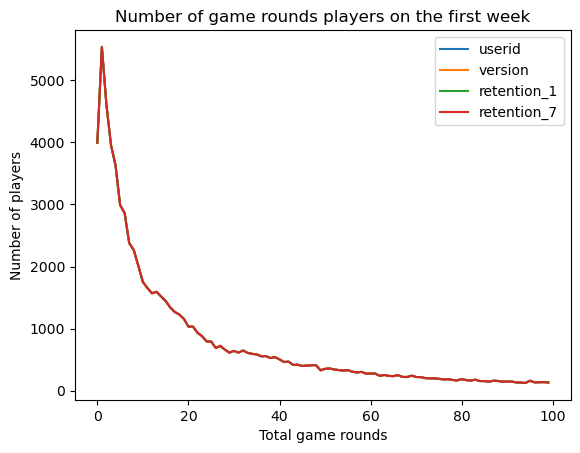

In [15]:
# Найдем сколько пользователь играет
plot_df = df.groupby('sum_gamerounds').count()

ax = plot_df[:100].plot()
ax.set_xlabel('Total game rounds')
ax.set_ylabel('Number of players')
ax.set_title('Number of game rounds players on the first week')

График показывает, что большенство пользователей играет менее 20 раундов.

Чтобы получить более детальное представление о низкой и высокой активности пользователей изменим наше распределение выборок.

Построим гистограммный график различных распределений групп AB.

In [16]:
plt.style.use('ggplot')

Group_A = df[df.version == 'gate_30']
print(Group_A.head())

Group_B = df[df.version == 'gate_40']
print(Group_B.head())

bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]
plot_GA = pd.DataFrame(Group_A.groupby(pd.cut(Group_A['sum_gamerounds'],
                                              bins=bins)).count())
plot_GB = pd.DataFrame(Group_B.groupby(pd.cut(Group_B['sum_gamerounds'],
                                              bins=bins)).count())

    userid  version  sum_gamerounds  retention_1  retention_7
0      116  gate_30               3        False        False
1      337  gate_30              38         True        False
6     1066  gate_30               0        False        False
11    2101  gate_30               0        False        False
13    2179  gate_30              39         True        False
   userid  version  sum_gamerounds  retention_1  retention_7
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
7    1444  gate_40               2        False        False


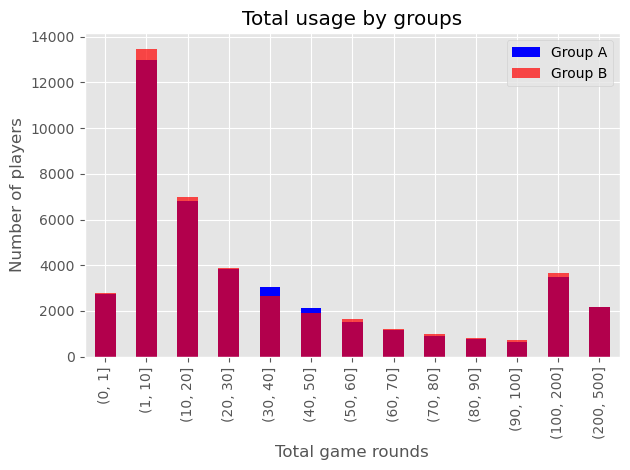

In [17]:
ax = plot_GA.plot(kind = 'bar', y='userid', color = 'blue', alpha = 1,
                  title = 'Total usage by groups')
plot_GB.plot(kind = 'bar', y = 'userid', ax = ax, color = 'red', alpha = 0.7)
ax.set_xlabel('Total game rounds')
ax.set_ylabel('Number of players')
plt.legend(['Group A', 'Group B'])
plt.tight_layout()
plt.grid(True)

Гафик показывает, что между двумя версиями вообщем нет большой разници.
Небольшие различия есть в пределах 30 - 40 сыгранных раундов.

Посмотрим какое удержание в течении 1 дня.

In [18]:
oneday = df.retention_1.sum()/df.retention_1.count()
print(str(oneday*100)+'%')

44.521444094558035%


Посмотрим какое удержание в течении 1 дня для групп.

In [19]:
oneday = df.retention_1.groupby(df.version).sum()/df.retention_1.groupby(df.version).count()
print(oneday*100)

version
gate_30    44.819795
gate_40    44.228275
Name: retention_1, dtype: float64


Обе версии имеют практически одинаковые результаты.
Четкого ответа, стоит ли применять изменение мы не получили.

Для принятия решения воспользуемся Bootstrapp для более детального иследования.

In [20]:
boot_1d = []
for i in range(500):
  boot_mean = df.retention_1.sample(frac=1, replace=True).groupby(df.version).mean()
  boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)
print(boot_1d)

version       gate_30   gate_40
retention_1  0.445294  0.441219
retention_1  0.448347  0.441345
retention_1  0.448240  0.445471
retention_1  0.449678  0.440237
retention_1  0.447970  0.443812
...               ...       ...
retention_1  0.449243  0.444525
retention_1  0.448734  0.440545
retention_1  0.447527  0.443740
retention_1  0.451079  0.443346
retention_1  0.449659  0.446375

[500 rows x 2 columns]


Text(0.5, 0, 'The average of 1-day retention')

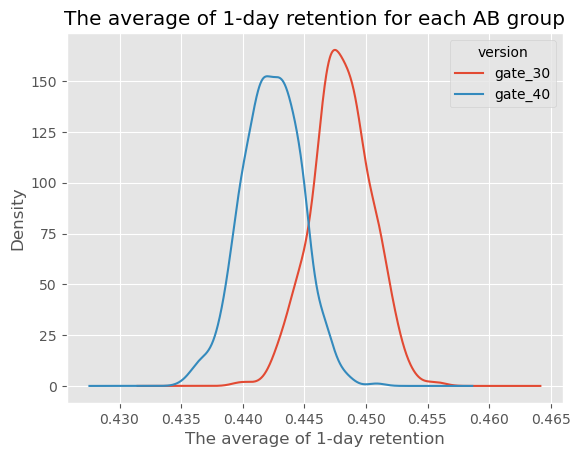

In [21]:
ax = boot_1d.plot.kde()
ax.set_title('The average of 1-day retention for each AB group')
ax.set_xlabel('The average of 1-day retention')

Увеличим разницу в удержании в течение 1 дня.

Text(0.5, 1.0, 'Zooming % difference')

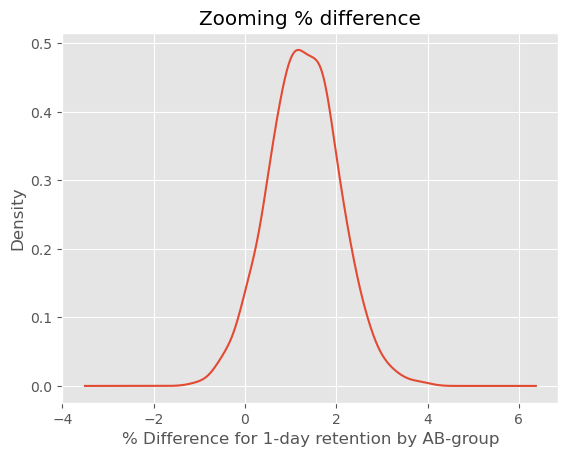

In [22]:
boot_1d['difference'] = (boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40']*100

ax = boot_1d['difference'].plot.kde()
ax.set_xlabel('% Difference for 1-day retention by AB-group')
ax.set_title('Zooming % difference')

Из графика видно, что наиболее вероятная разница 1-2% в пользу ворот на 30 уровне.

Посчитаем в скольки процентах случаев разница больше 0.

In [23]:
prob = (boot_1d['difference'] > 0).sum() / len(boot_1d['difference'])
print(str(prob*100)+'%')

95.8%


Вывод:
Существует высокая вероятность того, что удержание в течении 1 дня лучше, когда ворота находятся на уровне 30.

Дальше расчитае удержание в течении 7 дней для двух AB групп.

In [24]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

Здесь так же процент удержания выше у gate_30.

Для более точного расчета воспользуемся bootstrap-анализом.

In [25]:
boot_7d = []
for i in range(500):
  boot_mean = df.retention_7.sample(frac=1, replace=True).groupby(df.version).mean()
  boot_7d.append(boot_mean)

boot_7d = pd.DataFrame(boot_7d)
print(boot_7d.head())

boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100

version       gate_30   gate_40
retention_7  0.188479  0.179576
retention_7  0.189696  0.182851
retention_7  0.191024  0.179470
retention_7  0.189342  0.182917
retention_7  0.192135  0.181093


1.0


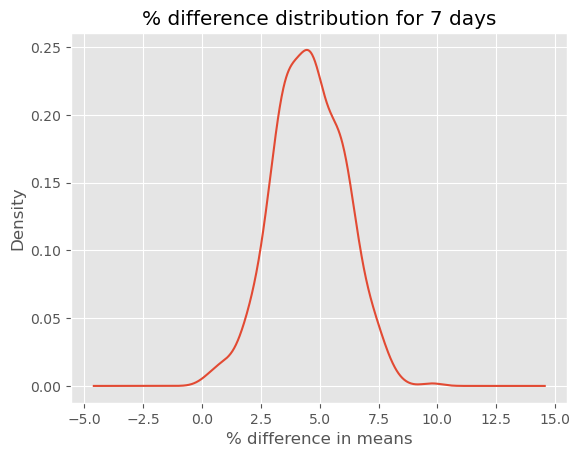

In [26]:
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel('% difference in means')
ax.set_title('% difference distribution for 7 days')

prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])

print(prob)

In [27]:
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])
print(str(prob*100)+'%')

100.0%


Вывод:
Наши иследования показали, что удержание в течении 7 дней выше, когда ворота ноходятся на уровне 30. Следовательно для удержания аудитории не рекомендуется перемещать варота с 30 уровня на 40.